# TP1 : Détection d’anomalies avec Python

---
---

*Jordan Dutel, Ariane Paradan* 

## I. Import des librairies

In [53]:
import numpy as np
np.set_printoptions(threshold=10000, suppress = True)

import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPathCollection
%matplotlib inline

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, roc_curve, precision_recall_curve, auc, f1_score, recall_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from collections import Counter

ModuleNotFoundError: No module named 'imblearn'

## II. Base de données Mouse

### A. Chargement et analyse rapide

In [3]:
mouse_data = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])
print(mouse_data)

           x1        x2
0    0.456601  0.432806
1    0.611378  0.528625
2    0.450299  0.711606
3    0.639015  0.460744
4    0.628957  0.323470
..        ...       ...
495  0.151506  0.876586
496  0.860308  0.633833
497  0.862083  0.591805
498  0.916030  0.523391
499  0.427325  0.833767

[500 rows x 2 columns]


In [4]:
print(mouse_data.describe())

               x1          x2
count  500.000000  500.000000
mean     0.505892    0.599706
std      0.191763    0.156863
min      0.040555    0.138940
25%      0.328481    0.469010
50%      0.504702    0.629494
75%      0.681430    0.735364
max      0.916030    0.897028


In [5]:
max_x1 = mouse_data['x1'].max()
max_x2 = mouse_data['x2'].max()
min_x1 = mouse_data['x1'].min()
min_x2 = mouse_data['x2'].min()

print(f"Max x1: {max_x1}")
print(f"Max x2: {max_x2}")
print(f"Min x1: {min_x1}")
print(f"Min x2: {min_x2}")

Max x1: 0.916029808381927
Max x2: 0.897027660749859
Min x1: 0.0405549277447862
Min x2: 0.1389403881484


### B. Représentation graphique

Text(0.5, 1.0, 'Scatter plot des coordonnées de mouse.txt')

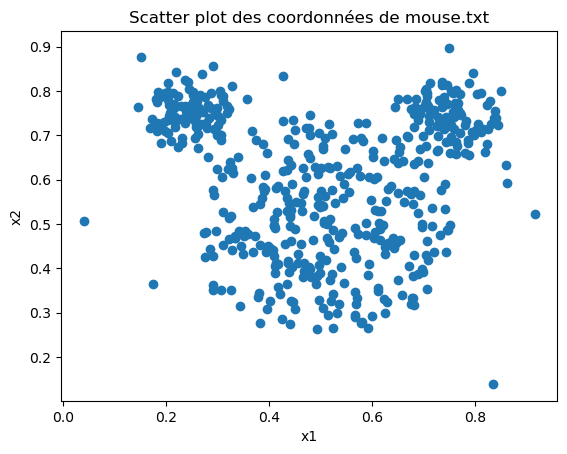

In [6]:
plt.scatter(mouse_data['x1'], mouse_data['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot des coordonnées de mouse.txt')

### C. Détection d'outlier par Isolation Forest

#### 1. Principe de l'algo

Isolation Forest est un algorithme d'apprentissage non supervisé utilisé pour détecter des anomalies ou des points de données qui sont différents (outliers) dans un ensemble de données. Il est particulièrement efficace pour travailler avec de grandes quantités de données et peut détecter des anomalies sans avoir besoin d'étiquettes (comme dans le cas des anomalies non étiquetées).

L'idée fondamentale derrière l'Isolation Forest repose sur l'idée que les anomalies sont plus faciles à "isoler" que les points normaux. Les anomalies sont souvent éloignées de la majorité des données, ce qui les rend plus faciles à séparer lors de la construction de "arbres" d'isolation.

Voici comment fonctionne l'algorithme :

- Isolation des points de données :
    - Le modèle crée plusieurs arbres (similaires à un arbre de décision), où chaque arbre "divise" les données de manière aléatoire. Pour chaque point, l'algorithme essaie de le séparer des autres points.
    - Les anomalies (points rares ou extrêmes) nécessitent moins de divisions pour être séparées des autres points. En d'autres termes, elles sont plus facilement "isolées" dans les arbres.

- Scores d'anomalie :
    - Chaque point de données reçoit un score d'anomalie basé sur le nombre de divisions nécessaires pour l'isoler. Plus un point a un score élevé, plus il est probable que ce soit une anomalie.
    - Le score est compris entre -1 et 1. Les points avec un score proche de -1 sont considérés comme des anomalies, tandis que ceux proches de 1 sont considérés comme normaux.

#### 2. Arguments de la fonction

- n_estimators :
    - Description : Le nombre d'arbres à utiliser dans la forêt.
    - Valeur par défaut : 100
    - Explication : Plus le nombre d'arbres est élevé, plus l'algorithme est susceptible de donner des résultats stables, mais cela augmentera aussi le temps de calcul. Un nombre typique est entre 100 et 200.

- max_samples :
    - Description : Le nombre maximum de points à utiliser pour entraîner chaque arbre.
    - Valeur par défaut : 'auto' (qui correspond à min(256, n_samples)).
    - Explication : Si tu as un grand nombre de points, tu peux réduire ce paramètre pour accélérer l'entraînement. Utiliser la valeur par défaut est souvent suffisant pour la plupart des cas, mais tu peux ajuster ce paramètre si tu travailles avec des ensembles de données très grands.

- contamination :
    - Description : La proportion estimée d'anomalies dans les données. Ce paramètre aide à déterminer quel seuil utiliser pour classer un point comme anomalie.
    - Valeur par défaut : 0.1 (10% des données seront considérées comme des anomalies).
    - Explication : Si tu sais approximativement quelle proportion de points dans ton ensemble de données est anormale, tu peux fournir cette valeur pour améliorer la détection des anomalies. Si tu ne connais pas cette proportion, laisse ce paramètre à sa valeur par défaut, mais il peut être nécessaire de l'ajuster en fonction de ton jeu de données.

- max_features :
    - Description : Le nombre maximum de caractéristiques (features) à utiliser pour entraîner chaque arbre.
    - Valeur par défaut : 1.0 (toutes les caractéristiques sont utilisées).
    - Explication : Cela peut être utile si tu as un grand nombre de dimensions (features) et que tu veux réduire le calcul en ne prenant qu'un sous-ensemble aléatoire de caractéristiques à chaque itération.

- bootstrap :
    - Description : Si True, chaque arbre est entraîné sur un échantillon aléatoire avec remplacement (bootstrap sampling).
    - Valeur par défaut : False
    - Explication : Cela peut être utile si tu veux entraîner les arbres sur des échantillons plus variés (mais cela pourrait affecter la performance).

- n_jobs :
    - Description : Le nombre de threads à utiliser pour entraîner les arbres.
    - Valeur par défaut : 1
    - Explication : Si tu veux accélérer le calcul, tu peux spécifier un nombre plus élevé de threads (par exemple, -1 pour utiliser tous les cœurs du processeur).

- random_state :
    - Description : Un nombre ou un objet pour contrôler la randomisation. Il permet de fixer la graine du générateur de nombres aléatoires pour garantir que les résultats soient reproductibles.
    - Valeur par défaut : None
    - Explication : Si tu veux que tes résultats soient reproductibles à chaque exécution, tu peux définir ce paramètre à un nombre fixe (par exemple, random_state=42).

- decision_function :
    - Description : Ce paramètre peut être utilisé pour obtenir la "fonction de décision" qui donne la confiance du modèle sur le fait qu'un point est une anomalie ou non.
    - Explication : Cela peut être utilisé pour obtenir un score pour chaque observation avant de décider de sa classification finale en anomalie.

#### 3. Construction du modèle

In [7]:
mouse_data_1 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

iso_forest_model = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination='auto', 
    max_features=1.0, 
    bootstrap=False,
    n_jobs=None, 
    random_state=None, 
    verbose=True, 
    warm_start=False)

iso_forest_model.fit(mouse_data_1)

IsolationForest(verbose=True)

In [8]:
# Prédire les anomalies
mouse_data_1['anomaly'] = iso_forest_model.predict(mouse_data_1)  # -1 pour outliers, 1 pour normales

# Séparer les points normaux des outliers
normals = mouse_data_1[mouse_data_1['anomaly'] == 1]
outliers = mouse_data_1[mouse_data_1['anomaly'] == -1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


#### 4. Visualisation des outliers

##### a. Représentation basique

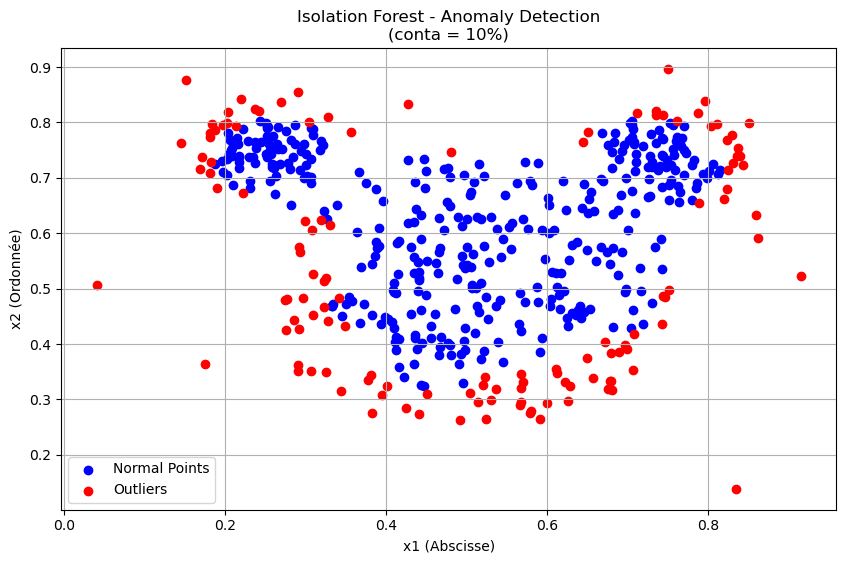

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(normals['x1'], normals['x2'], color='blue', label='Normal Points')
plt.scatter(outliers['x1'], outliers['x2'], color='red', label='Outliers')
plt.xlabel('x1 (Abscisse)')
plt.ylabel('x2 (Ordonnée)')
plt.legend()
plt.title('Isolation Forest - Anomaly Detection\n(conta = 10%)')
plt.grid(True)

##### b. Représentation avec des frontières

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


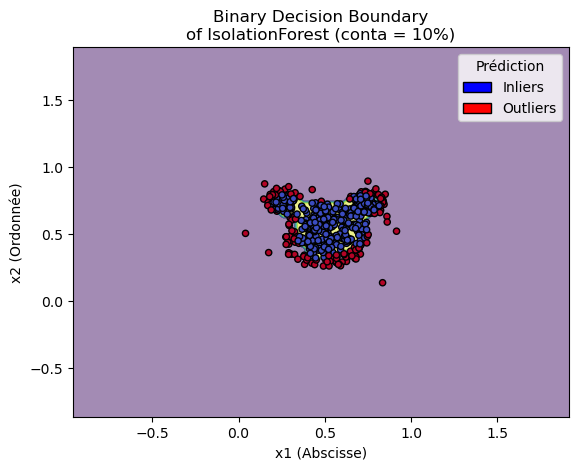

In [10]:
y_pred = mouse_data_1['anomaly'].replace({1: 0, -1: 1})  # 0 pour inliers, 1 pour outliers (pour le graphique)

# Visualisation des frontières de décision
disp = DecisionBoundaryDisplay.from_estimator(
    iso_forest_model,
    mouse_data_1[["x1", "x2"]],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(mouse_data_1["x1"], mouse_data_1["x2"], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")
disp.ax_.set_title("Binary Decision Boundary\nof IsolationForest (conta = 10%)")
disp.ax_.set_xlabel("x1 (Abscisse)")
disp.ax_.set_ylabel("x2 (Ordonnée)")
# plt.legend(["Inliers", "Outliers"], loc="upper right")

# Création d'une légende manuelle
legend_elements = [
    Patch(facecolor="blue", edgecolor="k", label="Inliers"),
    Patch(facecolor="red", edgecolor="k", label="Outliers"),
]
disp.ax_.legend(handles=legend_elements, loc="upper right", title="Prédiction")

#### 5. Amélioration du seuil de contamination

À propos de mouse.txt, on nous dit : 
>Ce fichier contient 500 instances décrites par deux variables x1 et x2 représentant des points de la tête de Mickey Mouse. Les 10 dernières instances du fichier sont aberrantes (outliers).

On a donc $\frac{10}{500}=2\%$ d'outliers

On peut donc modifier l'argument `contamination` de la fonction `IsolationForest()` lors de la construction du modèle, qui par défaut vaut 10%.

In [11]:
mouse_data_1_bis = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

iso_forest_model_1_bis = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination=0.02, 
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=None, 
    random_state=42, 
    verbose=True, 
    warm_start=False)

iso_forest_model_1_bis.fit(mouse_data_1_bis)

# Prédire les anomalies
mouse_data_1_bis['anomaly'] = iso_forest_model_1_bis.predict(mouse_data_1_bis)  # -1 pour outliers, 1 pour normales

# Séparer les points normaux des outliers
normals_1_bis = mouse_data_1_bis[mouse_data_1_bis['anomaly'] == 1]
outliers_1_bis = mouse_data_1_bis[mouse_data_1_bis['anomaly'] == -1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


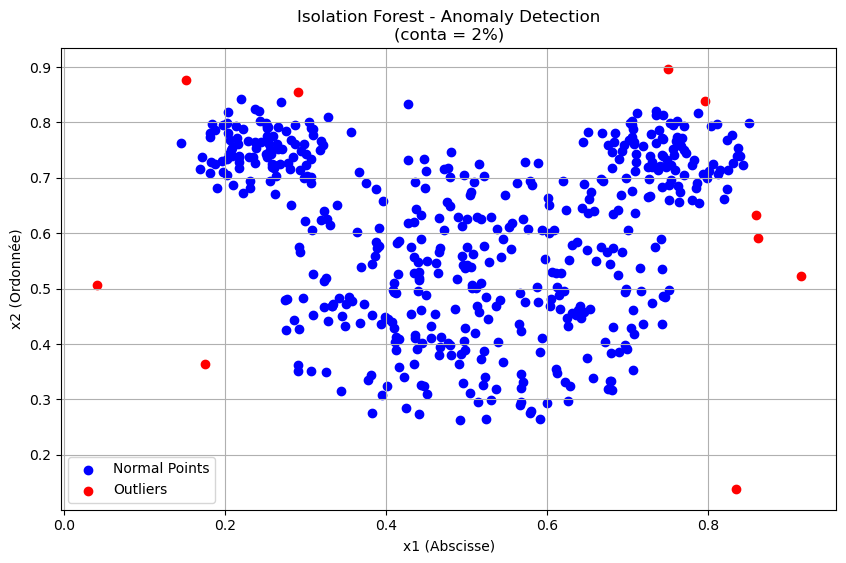

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(normals_1_bis['x1'], normals_1_bis['x2'], color='blue', label='Normal Points')
plt.scatter(outliers_1_bis['x1'], outliers_1_bis['x2'], color='red', label='Outliers')
plt.xlabel('x1 (Abscisse)')
plt.ylabel('x2 (Ordonnée)')
plt.legend()
plt.title('Isolation Forest - Anomaly Detection\n(conta = 2%)')
plt.grid(True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


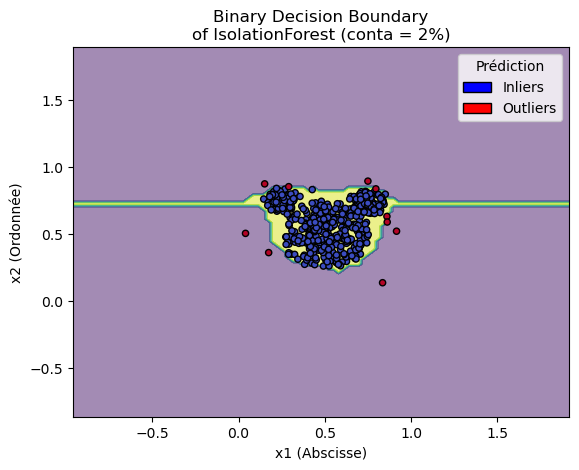

In [13]:
y_pred_1_bis = mouse_data_1_bis['anomaly'].replace({1: 0, -1: 1})  # 0 pour inliers, 1 pour outliers (pour le graphique)

# Visualisation des frontières de décision
disp_1_bis = DecisionBoundaryDisplay.from_estimator(
    iso_forest_model_1_bis,
    mouse_data_1_bis[["x1", "x2"]],
    response_method="predict",
    alpha=0.5,
)
disp_1_bis.ax_.scatter(mouse_data_1_bis["x1"], mouse_data_1_bis["x2"], c=y_pred_1_bis, cmap="coolwarm", s=20, edgecolor="k")
disp_1_bis.ax_.set_title("Binary Decision Boundary\nof IsolationForest (conta = 2%)")
disp_1_bis.ax_.set_xlabel("x1 (Abscisse)")
disp_1_bis.ax_.set_ylabel("x2 (Ordonnée)")
# plt.legend(["Inliers", "Outliers"], loc="upper right")

# Création d'une légende manuelle
legend_elements_1_bis = [
    Patch(facecolor="blue", edgecolor="k", label="Inliers"),
    Patch(facecolor="red", edgecolor="k", label="Outliers"),
]
disp_1_bis.ax_.legend(handles=legend_elements_1_bis, loc="upper right", title="Prédiction")

Essayons de représenter les scores prédit par Isolation Forest sous forme d'histogramme pour trouver un bon seuil de contamination

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


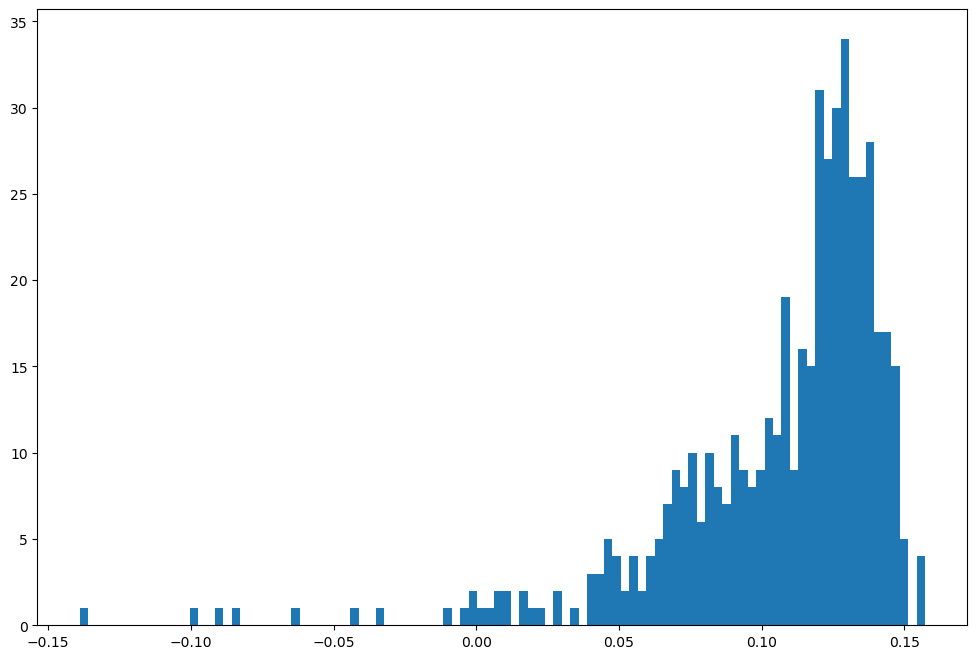

In [14]:
mouse_data_1_bis = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

scores = iso_forest_model_1_bis.decision_function(mouse_data_1_bis)

plt.figure(figsize=(12, 8))
plt.hist(scores, bins=100);

Contamination = 0.01


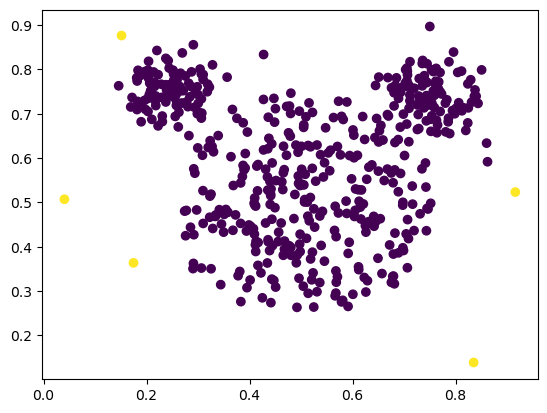

Contamination = 0.015


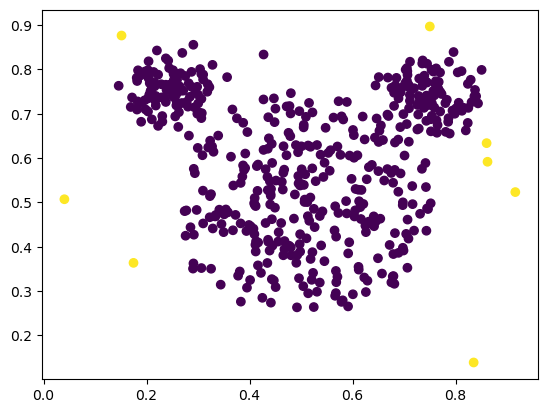

Contamination = 0.019999999999999997


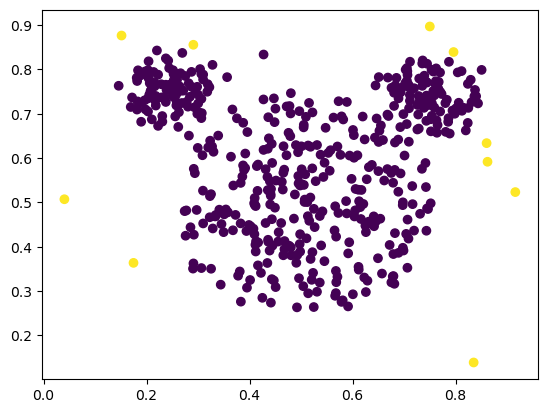

Contamination = 0.024999999999999998


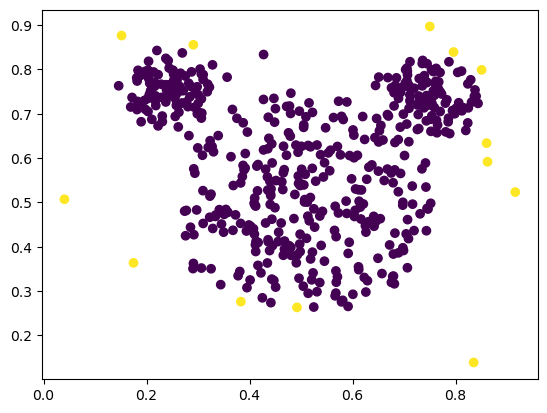

Contamination = 0.03


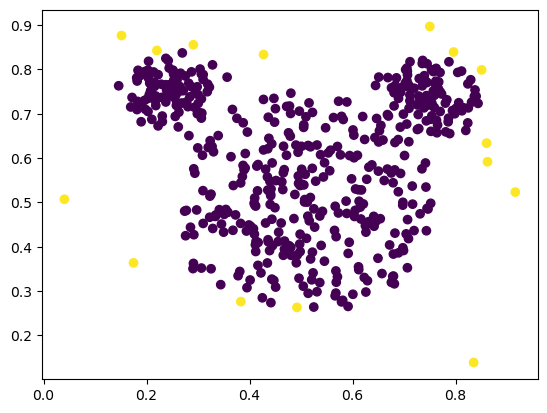

Contamination = 0.034999999999999996


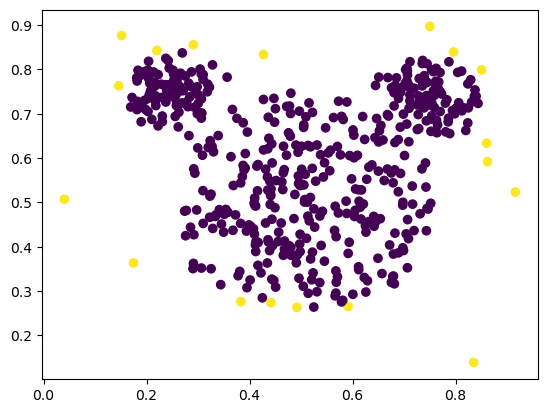

Contamination = 0.039999999999999994


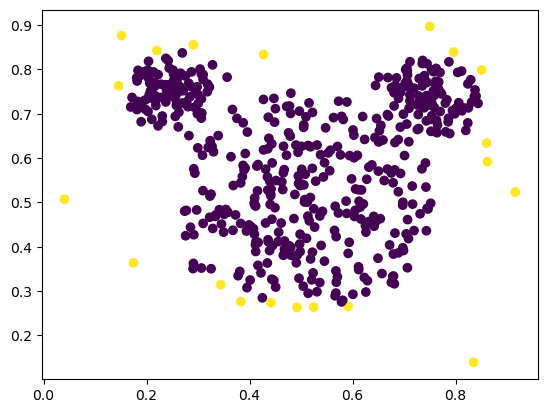

Contamination = 0.045


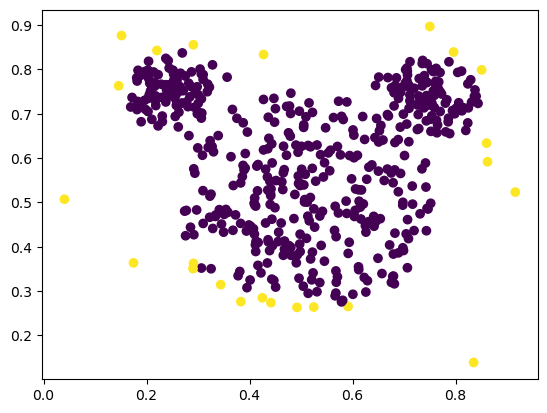

Contamination = 0.049999999999999996


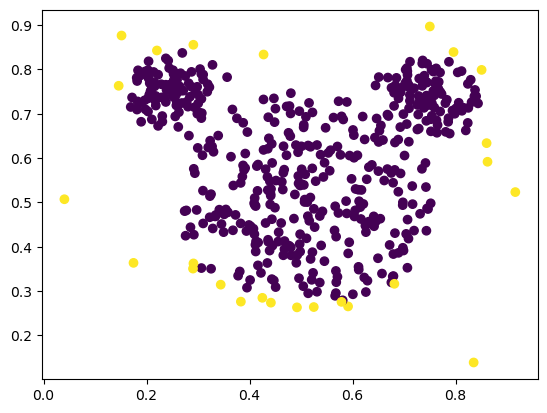

Contamination = 0.05499999999999999


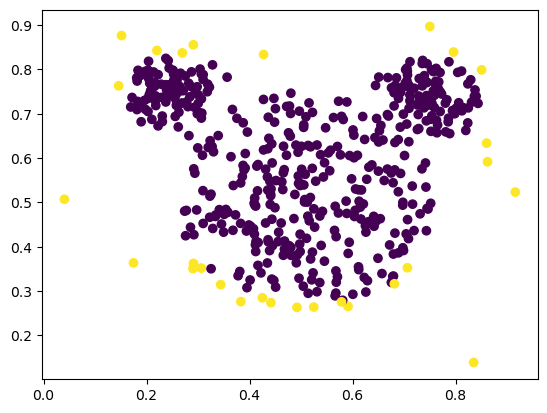

Contamination = 0.05999999999999999


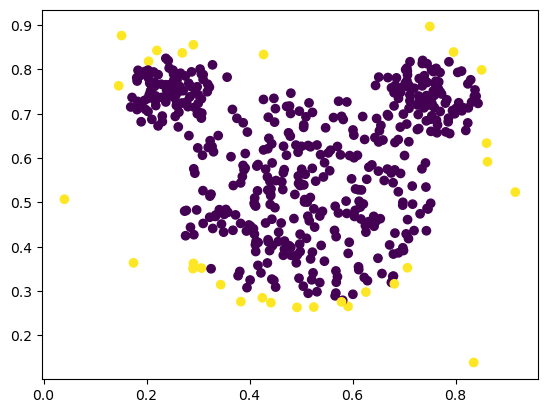

Contamination = 0.06499999999999999


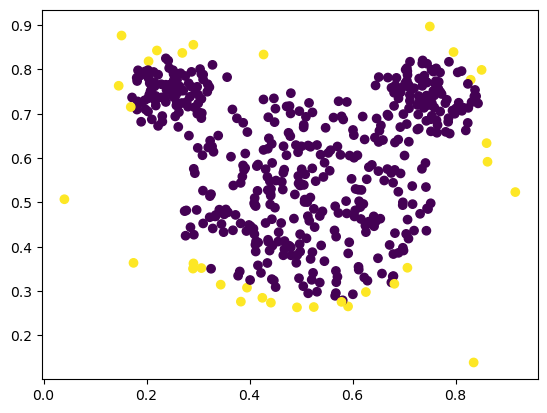

Contamination = 0.06999999999999999


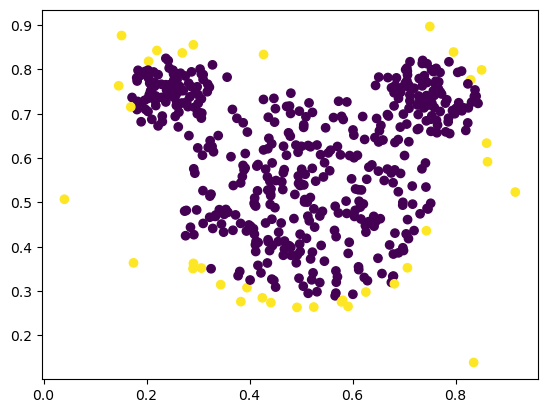

Contamination = 0.07499999999999998


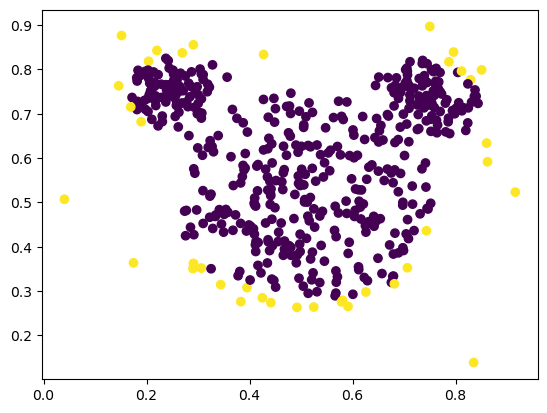

Contamination = 0.07999999999999999


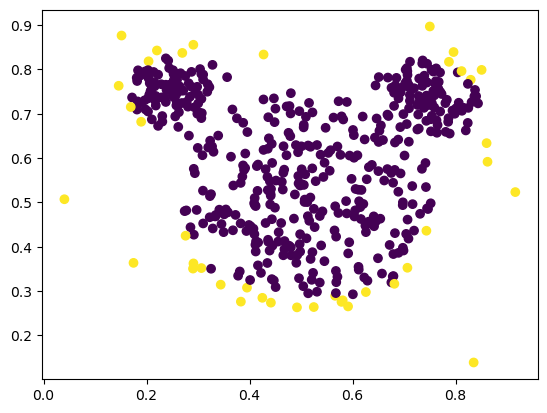

Contamination = 0.08499999999999998


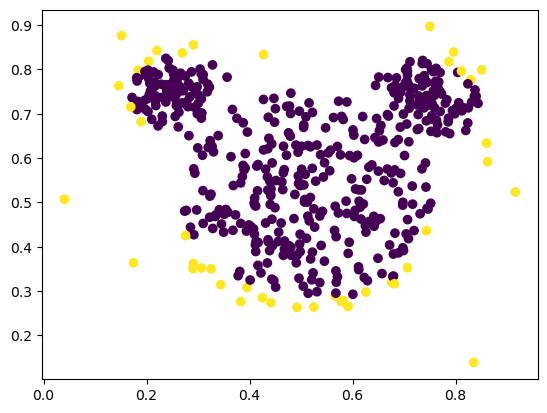

Contamination = 0.08999999999999998


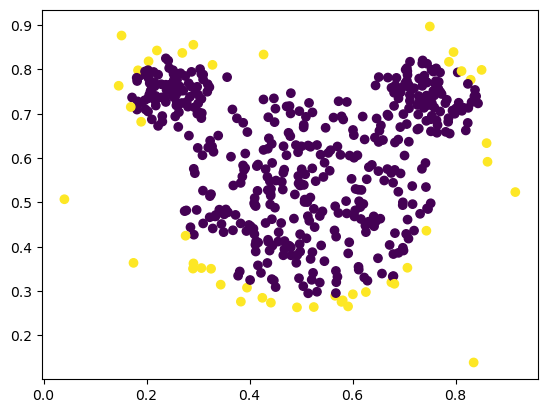

Contamination = 0.09499999999999999


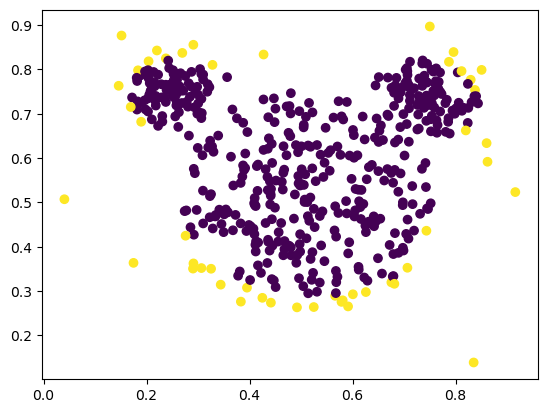

Contamination = 0.09999999999999998


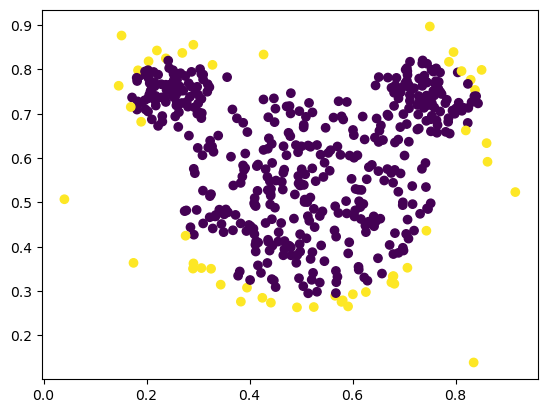

Contamination = 0.10499999999999998


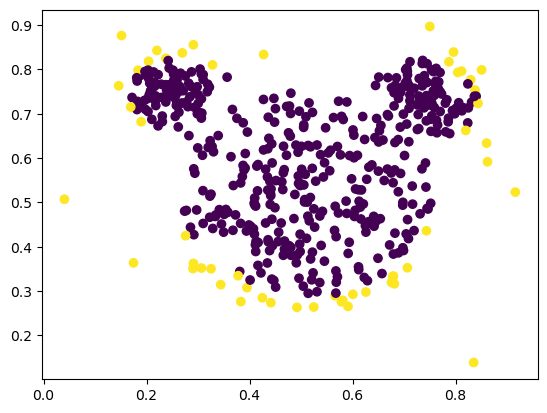

Contamination = 0.10999999999999997


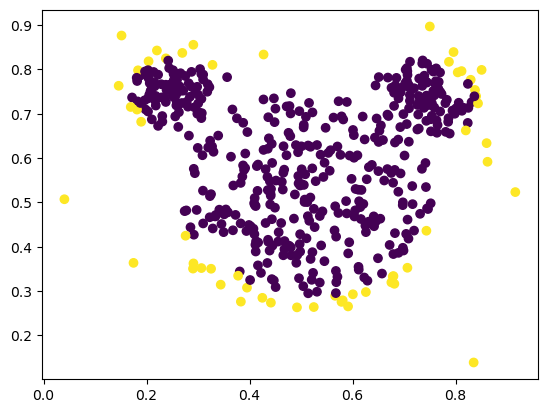

Contamination = 0.11499999999999998


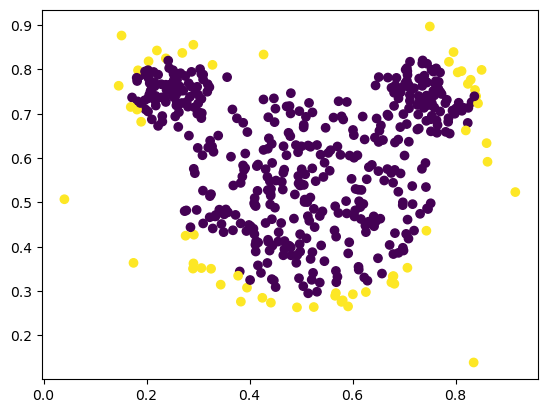

Contamination = 0.11999999999999998


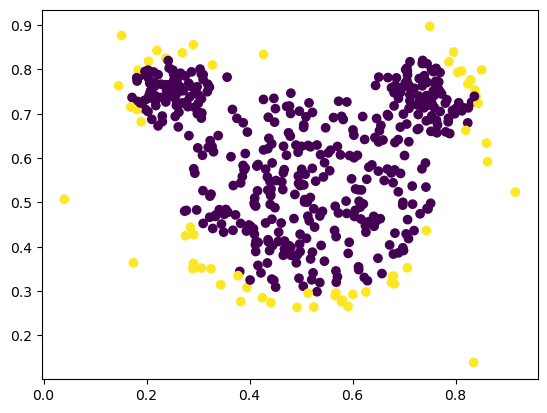

Contamination = 0.12499999999999997


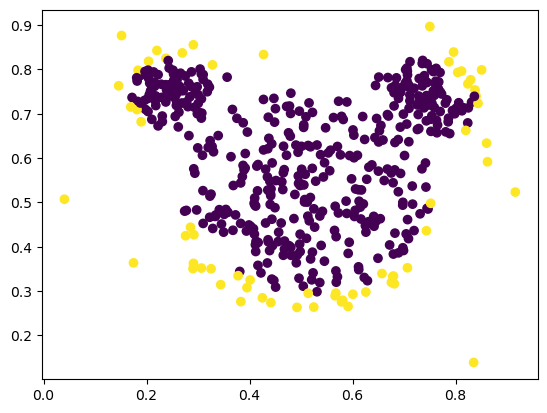

Contamination = 0.12999999999999998


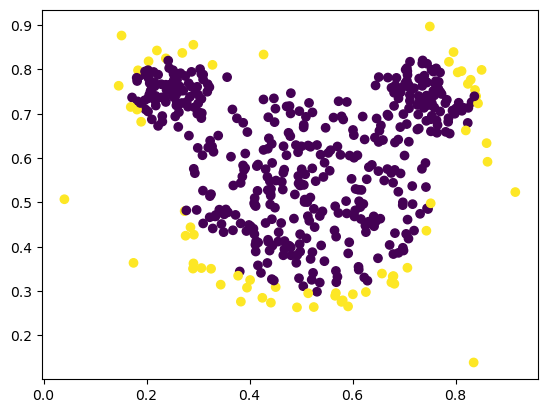

Contamination = 0.13499999999999998


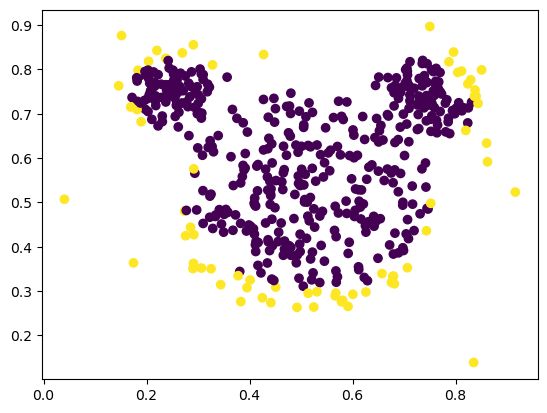

Contamination = 0.13999999999999999


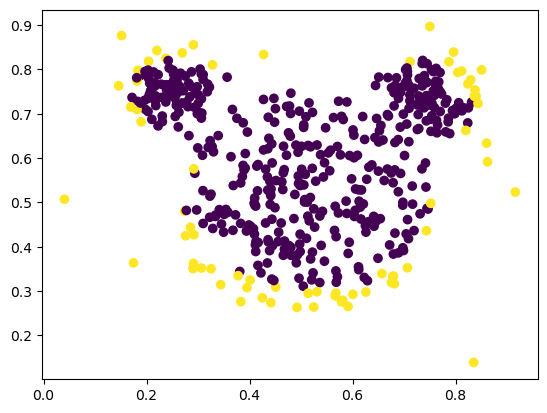

Contamination = 0.145


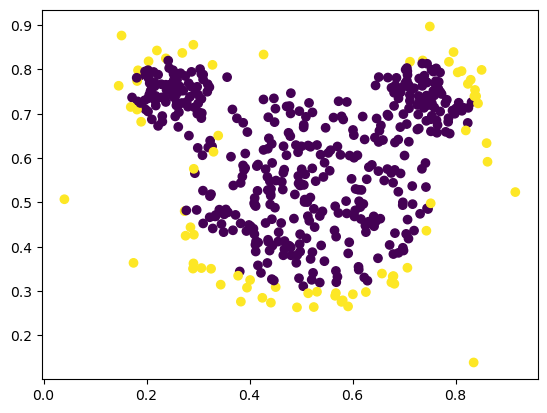

Contamination = 0.15


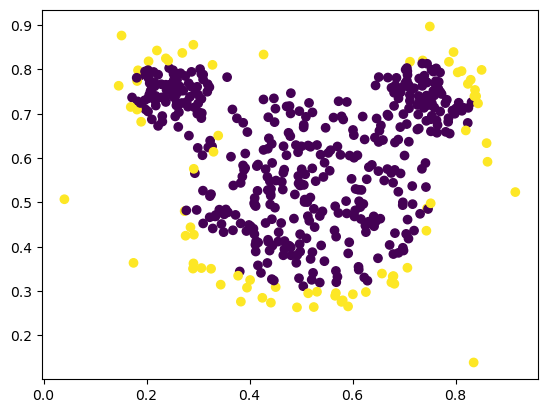

Contamination = 0.155


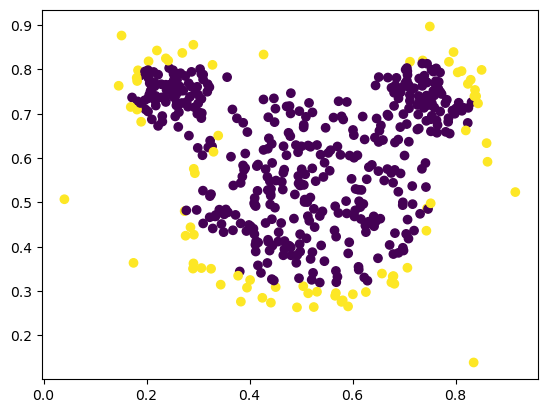

Contamination = 0.15999999999999998


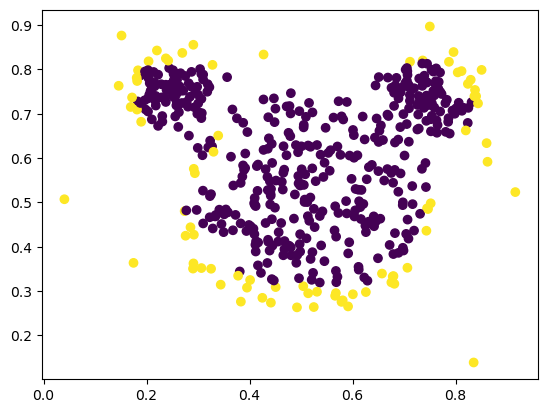

Contamination = 0.16499999999999998


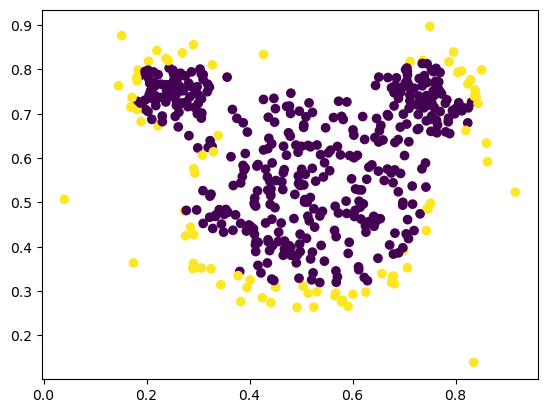

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Charger les données une seule fois
mouse_data_1_bis_original = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

# Boucle sur différentes valeurs de contamination
for i in np.arange(0.01, 0.17, 0.005):  # De 0.01 à 0.16 par pas de 0.01
    print(f"Contamination = {i}")

    # Créer une copie des données originales pour éviter de les modifier
    mouse_data_1_bis = mouse_data_1_bis_original.copy()

    # Configurer et entraîner le modèle Isolation Forest
    iso_forest_model_1_bis = IsolationForest(
        n_estimators=100, 
        max_samples='auto', 
        contamination=i, 
        max_features=1.0, 
        bootstrap=False, 
        random_state=42, 
        verbose=False, 
        warm_start=False)

    iso_forest_model_1_bis.fit(mouse_data_1_bis)

    # Calculer les scores de décision
    scores = iso_forest_model_1_bis.decision_function(mouse_data_1_bis)

    # Prédire les anomalies
    anomalies = iso_forest_model_1_bis.predict(mouse_data_1_bis)  # -1 pour outliers, 1 pour normales

    # Ajouter les anomalies dans un DataFrame séparé (si nécessaire)
    mouse_data_1_bis['anomaly'] = anomalies

    treshold = 0.0
    anomaly=scores.copy()
    anomaly[scores<=treshold]=1
    anomaly[scores>treshold]=0
    anomaly
    plt.scatter(mouse_data_1_bis.iloc[:, 0], mouse_data_1_bis.iloc[:, 1], c=anomaly, cmap=plt.get_cmap('viridis'))
    plt.show()



En fixant un seuil fixe et en faisant varier la contamination, on peut regarder visuellement si les points sont bel et bien outliers selon les différentes contaminations.

### D. Détection d'outlier par Local Outlier Factor (LOF)

#### 1. Modèle LOF avec contamination par défaut

##### a. Model training

In [16]:
mouse_data_lof_1 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

Lof_model_1 = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination='auto', 
    novelty=False, 
    n_jobs=None)
    
y_pred_lof_1 = Lof_model_1.fit_predict(mouse_data_lof_1)
mouse_data_lof_1_scores = Lof_model_1.negative_outlier_factor_

##### b. Représentation graphique

Text(0.5, 1.0, 'Local Outlier Factor (LOF)\n(conta = 10%)')

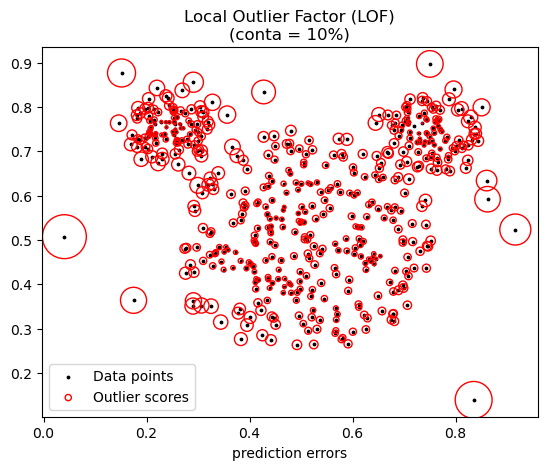

In [17]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(mouse_data_lof_1.iloc[:, 0], mouse_data_lof_1.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min())
scatter = plt.scatter(
    mouse_data_lof_1.iloc[:, 0],
    mouse_data_lof_1.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors")
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)\n(conta = 10%)")

In [18]:
# def update_legend_marker_size(handle, orig):
#     """Customize size of the legend marker."""
#     handle.update_from(orig)
#     handle.set_sizes([20])

# # Normalisation des scores pour ajuster la taille des points
# radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (
#     mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min()
# )

# # Points normaux
# plt.scatter(
#     mouse_data_lof_1.iloc[:, 0],
#     mouse_data_lof_1.iloc[:, 1],
#     color="k",
#     s=3.0,
#     label="Inliers"
# )

# # Points anormaux avec tailles proportionnelles aux scores
# scatter = plt.scatter(
#     mouse_data_lof_1.iloc[:, 0],
#     mouse_data_lof_1.iloc[:, 1],
#     c=radius,  # Utilisation de couleurs (peut aussi être "red" pour une seule couleur)
#     cmap="coolwarm",  # Palette pour représenter les scores
#     s=100 * radius,  # Taille proportionnelle aux scores
#     label="Outlier scores"
# )

# # Ajustements de l'affichage
# plt.axis("tight")
# plt.xlabel("Prediction errors")
# plt.colorbar(scatter, label="Normalized LOF Scores")  # Ajouter une barre de couleur
# plt.legend(
#     handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
# )
# plt.title("Local Outlier Factor (LOF)")
# plt.show()


#### 2. Modèle LOF avec contamination à 2%

##### a. Model training

In [19]:
mouse_data_lof_2 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

Lof_model_2 = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination=0.02, 
    novelty=False, 
    n_jobs=None)
    
y_pred_lof_2 = Lof_model_2.fit_predict(mouse_data_lof_2)
mouse_data_lof_2_scores = Lof_model_2.negative_outlier_factor_

##### b. Représentation graphique

Text(0.5, 1.0, 'Local Outlier Factor (LOF)\n(conta = 2%)')

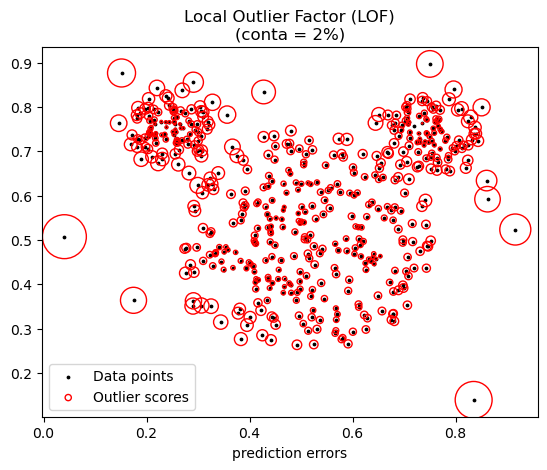

In [20]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(mouse_data_lof_2.iloc[:, 0], mouse_data_lof_2.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores) / (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores.min())
scatter = plt.scatter(
    mouse_data_lof_2.iloc[:, 0],
    mouse_data_lof_2.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors")
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)\n(conta = 2%)")

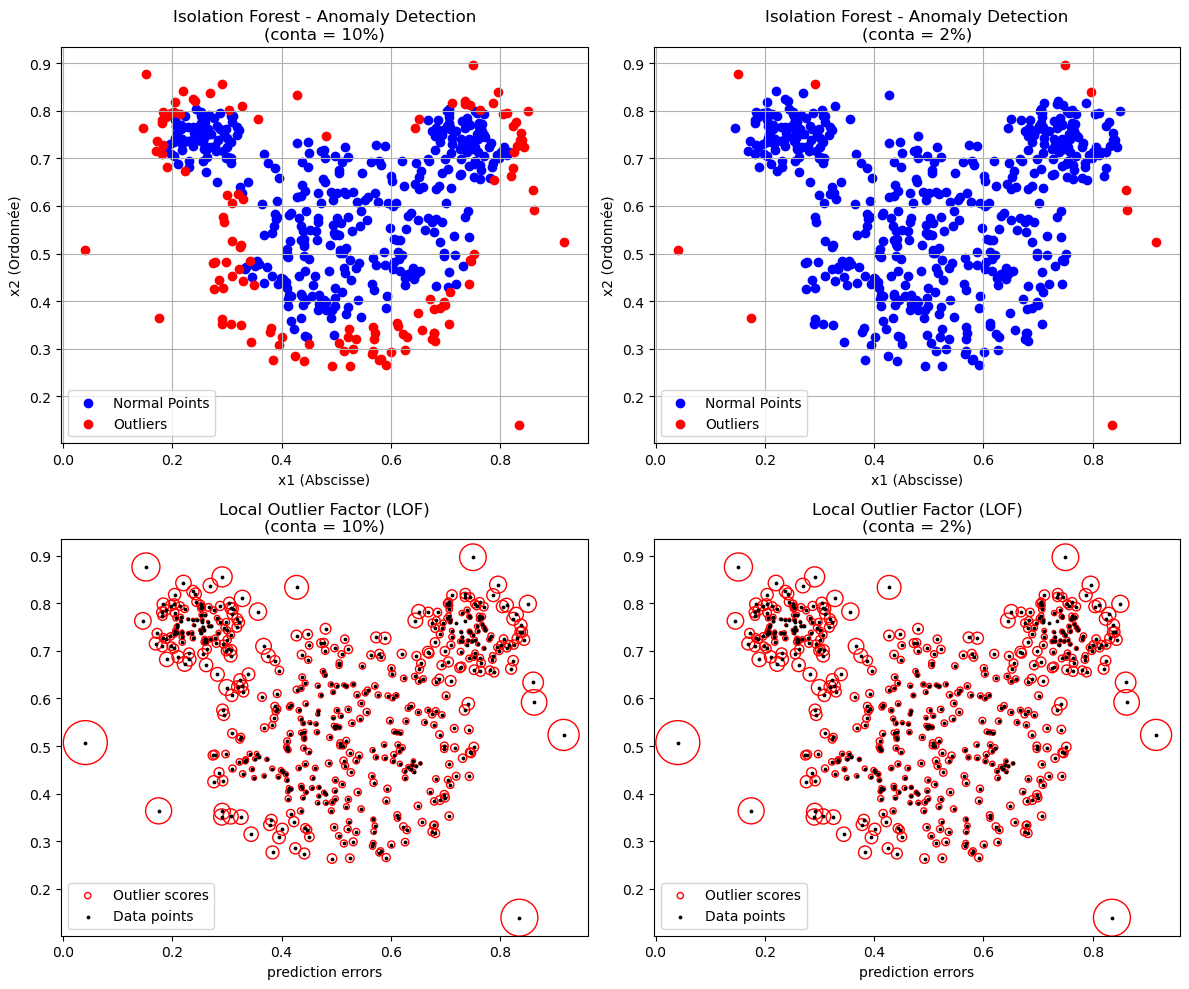

In [21]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

# Créer une figure principale avec 2x2 sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Figure 1 - Isolation Forest (conta = 10%)
axs[0, 0].scatter(normals['x1'], normals['x2'], color='blue', label='Normal Points')
axs[0, 0].scatter(outliers['x1'], outliers['x2'], color='red', label='Outliers')
axs[0, 0].set_xlabel('x1 (Abscisse)')
axs[0, 0].set_ylabel('x2 (Ordonnée)')
axs[0, 0].legend()
axs[0, 0].set_title('Isolation Forest - Anomaly Detection\n(conta = 10%)')
axs[0, 0].grid(True)

# Figure 2 - Isolation Forest (conta = 2%)
axs[0, 1].scatter(normals_1_bis['x1'], normals_1_bis['x2'], color='blue', label='Normal Points')
axs[0, 1].scatter(outliers_1_bis['x1'], outliers_1_bis['x2'], color='red', label='Outliers')
axs[0, 1].set_xlabel('x1 (Abscisse)')
axs[0, 1].set_ylabel('x2 (Ordonnée)')
axs[0, 1].legend()
axs[0, 1].set_title('Isolation Forest - Anomaly Detection\n(conta = 2%)')
axs[0, 1].grid(True)

# Figure 3 - Local Outlier Factor (conta = 10%)
radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min())
scatter = axs[1, 0].scatter(
    mouse_data_lof_1.iloc[:, 0],
    mouse_data_lof_1.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
axs[1, 0].scatter(mouse_data_lof_1.iloc[:, 0], mouse_data_lof_1.iloc[:, 1], color="k", s=3.0, label="Data points")
axs[1, 0].set_xlabel("prediction errors")
axs[1, 0].set_title("Local Outlier Factor (LOF)\n(conta = 10%)")
axs[1, 0].legend(
    handler_map={scatter: HandlerPathCollection(update_func=lambda h, o: h.update_from(o) or h.set_sizes([20]))}
)

# Figure 4 - Local Outlier Factor (conta = 2%)
radius = (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores) / (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores.min())
scatter = axs[1, 1].scatter(
    mouse_data_lof_2.iloc[:, 0],
    mouse_data_lof_2.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
axs[1, 1].scatter(mouse_data_lof_2.iloc[:, 0], mouse_data_lof_2.iloc[:, 1], color="k", s=3.0, label="Data points")
axs[1, 1].set_xlabel("prediction errors")
axs[1, 1].set_title("Local Outlier Factor (LOF)\n(conta = 2%)")
axs[1, 1].legend(
    handler_map={scatter: HandlerPathCollection(update_func=lambda h, o: h.update_from(o) or h.set_sizes([20]))}
)

# Ajuster les espaces entre les sous-graphes
fig.tight_layout()

Faire un histogramme des score prédit par isolation.forest_model.decision_fonction

## II. Détection de fraudes bancaires

### A. Préparation du jeu de donnée

#### 1. Charger les données

In [34]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 2. On décrit les données 

In [35]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [37]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

#### 3. On regarde le nombre de valeur NULL 

In [36]:
df.isnull().sum().max()

np.int64(0)

Pas de valeur nulle

#### 4. Les données sont-elles équilibrées ou déséquilibrées ?

Pourcentage de fraude: 0.17%
Pourcentage de non-fraude: 99.83%


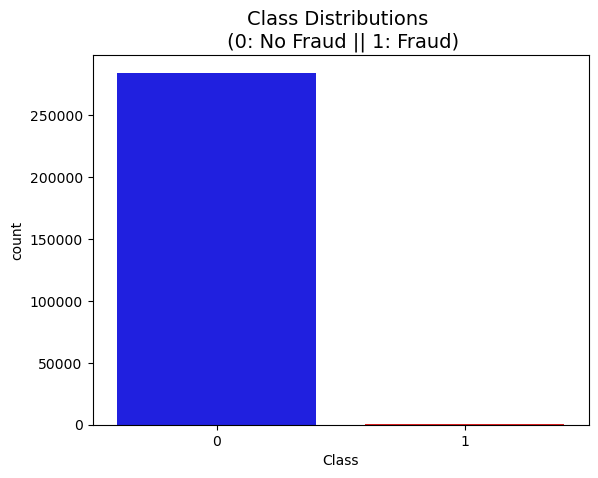

In [48]:
fraude = df['Class'].value_counts()[1]
non_fraude = df['Class'].value_counts()[0]
fraude_percent = (fraude / (fraude + non_fraude)) * 100
non_fraude_percent = (non_fraude / (fraude + non_fraude)) * 100

colors = ["blue", "red"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

print(f"Pourcentage de fraude: {fraude_percent:.2f}%")
print(f"Pourcentage de non-fraude: {non_fraude_percent:.2f}%")


Les données sont très déséquilibrés !!! (Une des classe est très très majoritaire comparé à l'autre)

#### 5. Supprimons la colonne Time

In [46]:
df.drop(['Time'], axis=1, inplace=True)

#### 6. Normalisons la colonne Amount

In [47]:
std_scaler = StandardScaler()

df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop(['Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']

df.drop(['scaled_amount'], axis=1, inplace=True)

df.insert(0, 'scaled_amount', scaled_amount)

df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


#### 7. Faire un échantillon aléatoire stratifié du jeu de données

Le jeu de donnée d'origine est très grand, on va donc faire, grace à StratifiedShuffleSplit, 3 echantillons réduits du jeu de donné pour que cela soit plus manipulables, et on pourra faire des valisations croisées stratifiées entre ces 3 échantillons

In [49]:
# Séparer les caractéristiques (X) et la cible (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Configurer StratifiedShuffleSplit
# n_splits=3 pour 3 splits, test_size=0.3 pour 30% des données de test, random_state=42 pour la reproductibilité
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

# Effectuer le split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


y_train distribution:
 Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64
y_test distribution:
 Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


In [50]:
# Vérifier la répartition
print("Répartition dans les données originales :")
print(y.value_counts(normalize=True))
print("\nRépartition dans l'ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))
print("\nRépartition dans l'ensemble de test :")
print(y_test.value_counts(normalize=True))

Répartition dans les données originales :
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Répartition dans l'ensemble d'entraînement :
Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

Répartition dans l'ensemble de test :
Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


Les répartitions des classes dans les échantillons sont équivalentes

### B. Detection d'outliers

#### 1. Régression Logistique & Random Forest Vs Over-sampling & Under-sampling & Hybrid-sampling

On va comparer :
- Les approches supervisées classiques :
    - Régression Logistique
    - Random Forest 
- Les approches gérant le déséquilibre dans les données en amont :
    - Over-sampling (SMOTE) + Régression Logistique ou Random Forest
    - Under-sampling + Régression Logistique ou Random Forest
    - Hybrid-sampling + Régression Logistique ou Random Forest

In [ ]:
# Approche supervisée classique : Régression Logistique
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print(classification_report(y_test, y_pred_logreg))

# Approche supervisée classique : Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.64      0.73       148

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.82      0.88       148

    accuracy                           1.00     85443
   macro avg       0.98      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



#### 2. Isolation Forest VS Local Outlier Factor